In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
heart = pd.read_csv('heart_2020_cleaned.csv')
# keep all the yes
stratify_list = ['AgeCategory', 'Stroke', 'Sex', 'GenHealth']
heartYes = heart[heart.HeartDisease == 'Yes']
# keep 10% of the no
heartNo = heart[heart.HeartDisease == 'No']
no_sample = heartNo.groupby(stratify_list, group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state = 42))
# merge yes and no back
heart50 = pd.concat([heartYes, no_sample], axis = 0)
heart50 = heart50.sample(frac=1).reset_index(drop=True) # shuffle rows, reset index
# fix the predictors
#agecategories = list(heart50.AgeCategory.unique())
#ageMidpoints = [57, 90, 67, 77, 42, 72, 62, 52, 47, 21, 37, 32, 27]
#heart50.AgeCategory.replace(agecategories, ageMidpoints, inplace = True)
#healthcategories = list(heart50.GenHealth.unique())
#healthlevels = [4, 2, 3, 1, 5]
#heart50.GenHealth.replace(healthcategories, healthlevels, inplace = True)
bin_columns = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]
heart50[bin_columns] = heart50[bin_columns].apply(lambda x: x.map({'Yes':1,'No':0}))
categoricals = heart50.select_dtypes(include=['object'])
cat_dummies = pd.get_dummies(categoricals, drop_first=True)
heart50.drop(list(categoricals.columns), axis=1, inplace=True)
heart50 = pd.concat([heart50, cat_dummies], axis=1)

### 50-50 Split Data

In [28]:
#train50, test50 = train_test_split(heart50, test_size = 0.2, random_state = 42, stratify = heart50.HeartDisease)

In [2]:
train50 = pd.read_csv('train50.csv')
test50 = pd.read_csv('test50.csv')

In [3]:
y_train = train50['HeartDisease']
X_train = train50.drop(['HeartDisease'], axis = 1)

y_test = test50['HeartDisease']
X_test = test50.drop(['HeartDisease'], axis = 1)

In [4]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [5]:
# Make predictions on test data
predictions = logreg.predict(X_test)
# Performance
acc = round(metrics.accuracy_score(y_test, predictions)*100, 3)
print("Accuracy: ", acc, '%')

Accuracy:  72.343 %


In [38]:
# Class Errors
confuse = metrics.confusion_matrix(y_test, predictions)
print("Class No Accuracy: %f" % (confuse[0,0] / sum(confuse[0,:])))
print("Class Yes Accuracy: %f" % (confuse[1,1] / sum(confuse[1,:])))

Class No Accuracy: 0.776941
Class Yes Accuracy: 0.666301


In [39]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5846
           1       0.74      0.67      0.70      5475

    accuracy                           0.72     11321
   macro avg       0.72      0.72      0.72     11321
weighted avg       0.72      0.72      0.72     11321



In [11]:
# print as latex code
rep = metrics.classification_report(y_test, predictions, output_dict=True)
pdrep = pd.DataFrame(rep).transpose()
print(pdrep.style.to_latex())

\begin{tabular}{lrrrr}
{} & {precision} & {recall} & {f1-score} & {support} \\
0 & 0.713142 & 0.776941 & 0.743676 & 5846.000000 \\
1 & 0.736672 & 0.666301 & 0.699722 & 5475.000000 \\
accuracy & 0.723434 & 0.723434 & 0.723434 & 0.723434 \\
macro avg & 0.724907 & 0.721621 & 0.721699 & 11321.000000 \\
weighted avg & 0.724521 & 0.723434 & 0.722419 & 11321.000000 \\
\end{tabular}



Text(0.5, 0, 'False Positive Rate')

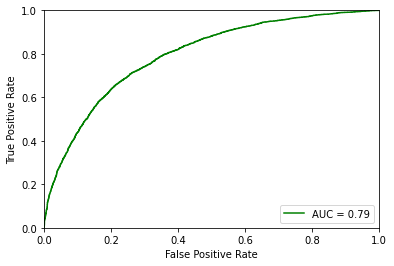

In [40]:
# plot ROC
pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('LG50_ROC.png')

In [7]:
df_var = pd.DataFrame(zip(X_train.columns, logreg.coef_[0]))
df_var.sort_values(by = [1], inplace = True, ascending = False, key = abs)
df_var

,0,1
3,Stroke,1.479394
12,KidneyDisease,0.963510
21,Diabetic_Yes,0.933339
6,DiffWalking,0.724970
15,Race_Asian,-0.654391
13,SkinCancer,0.630371
14,Sex_Male,0.617047
1,Smoking,0.496087
2,AlcoholDrinking,-0.475646
20,"Diabetic_No, borderline diabetes",0.464802


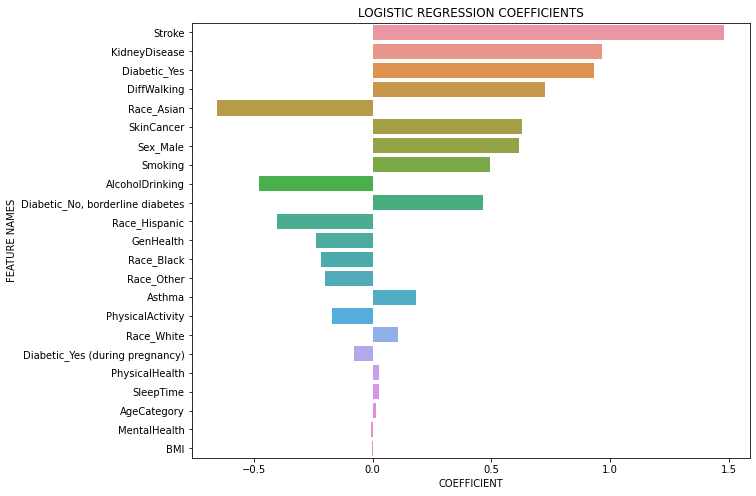

In [8]:
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=df_var[1], y=df_var[0])
#Add chart labels
plt.title('LOGISTIC REGRESSION COEFFICIENTS')
plt.xlabel('COEFFICIENT')
plt.ylabel('FEATURE NAMES')
plt.savefig('logreg_fi.png')

`scikit-learn` doesn't support statistical inferences, so we use `statsmodel` for this.

In [16]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.555043
         Iterations 6
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.199     
Dependent Variable:       HeartDisease          AIC:                   50312.8819
Date:                     2022-04-20 07:19      BIC:                   50513.4572
No. Observations:         45282                 Log-Likelihood:        -25133.   
Df Model:                 22                    LL-Null:               -31363.   
Df Residuals:             45259                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           6.0000                                                 
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

### SMOTE

In [2]:
os_train = pd.read_csv('train_smoted.csv')
os_test = pd.read_csv('test_smoted.csv')

In [19]:
os_train.groupby('HeartDisease').count()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,PhysicalActivity,GenHealth,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
HeartDisease,,,,,,,,,,,,,,,,,,,,,
0,23385,23385,23385,23385,23385,23385,23385,23385,23385,23385,...,23385,23385,23385,23385,23385,23385,23385,23385,23385,23385
1,23385,23385,23385,23385,23385,23385,23385,23385,23385,23385,...,23385,23385,23385,23385,23385,23385,23385,23385,23385,23385


In [18]:
y_train = os_train['HeartDisease']
X_train = os_train.drop(['HeartDisease'], axis = 1)

y_test = os_test['HeartDisease']
X_test = os_test.drop(['HeartDisease'], axis = 1)

In [19]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [20]:
# Make predictions on test data
predictions = logreg.predict(X_test)
# Performance
acc = round(metrics.accuracy_score(y_test, predictions)*100, 3)
print("Accuracy: ", acc, '%')

Accuracy:  77.574 %


In [21]:
# Class Errors
confuse = metrics.confusion_matrix(y_test, predictions)
print("Class No Accuracy: %f" % (confuse[0,0] / sum(confuse[0,:])))
print("Class Yes Accuracy: %f" % (confuse[1,1] / sum(confuse[1,:])))

Class No Accuracy: 0.800171
Class Yes Accuracy: 0.513761


In [22]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      5845
           1       0.19      0.51      0.28       545

    accuracy                           0.78      6390
   macro avg       0.57      0.66      0.57      6390
weighted avg       0.88      0.78      0.82      6390



In [23]:
# print as latex code
rep = metrics.classification_report(y_test, predictions, output_dict=True)
pdrep = pd.DataFrame(rep).transpose()
print(pdrep.style.to_latex())

\begin{tabular}{lrrrr}
{} & {precision} & {recall} & {f1-score} & {support} \\
0 & 0.946378 & 0.800171 & 0.867155 & 5845.000000 \\
1 & 0.193370 & 0.513761 & 0.280983 & 545.000000 \\
accuracy & 0.775743 & 0.775743 & 0.775743 & 0.775743 \\
macro avg & 0.569874 & 0.656966 & 0.574069 & 6390.000000 \\
weighted avg & 0.882154 & 0.775743 & 0.817161 & 6390.000000 \\
\end{tabular}



Text(0.5, 0, 'False Positive Rate')

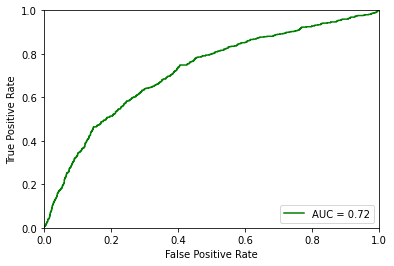

In [24]:
# plot ROC
pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('LG50_ROC.png')

In [25]:
df_var = pd.DataFrame(zip(X_train.columns, logreg.coef_[0]))
df_var.sort_values(by = [1], inplace = True, ascending = False, key = abs)
df_var

,0,1
15,Race_Asian,-5.519197
17,Race_Hispanic,-4.587140
16,Race_Black,-4.304650
18,Race_Other,-4.172922
19,Race_White,-2.734431
2,AlcoholDrinking,-2.336427
22,Diabetic_Yes (during pregnancy),-2.303795
20,"Diabetic_No, borderline diabetes",-1.225688
11,Asthma,-0.869965
8,PhysicalActivity,-0.794103


Text(0, 0.5, 'FEATURE NAMES')

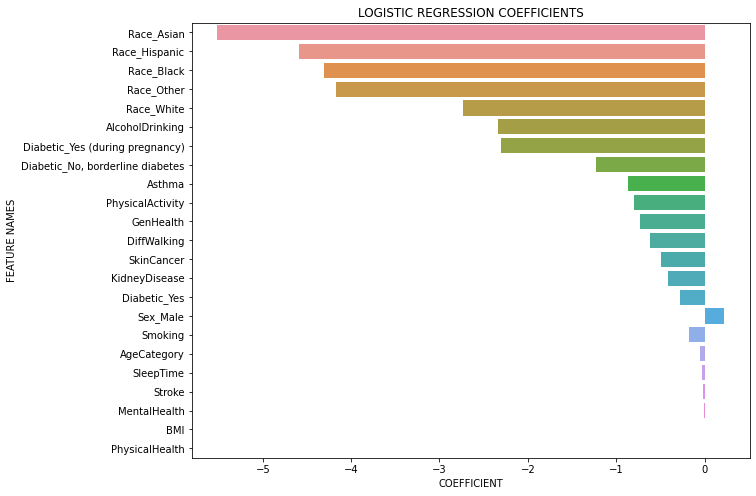

In [26]:
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=df_var[1], y=df_var[0])
#Add chart labels
plt.title('LOGISTIC REGRESSION COEFFICIENTS')
plt.xlabel('COEFFICIENT')
plt.ylabel('FEATURE NAMES')
#plt.savefig('logreg_fi.png')
#plt.savefig('logreg_fi.pdf')

`scikit-learn` doesn't support statistical inferences, so we use `statsmodel` for this.

In [ ]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.555043
         Iterations 6
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.199     
Dependent Variable:       HeartDisease          AIC:                   50312.8819
Date:                     2022-04-20 07:19      BIC:                   50513.4572
No. Observations:         45282                 Log-Likelihood:        -25133.   
Df Model:                 22                    LL-Null:               -31363.   
Df Residuals:             45259                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           6.0000                                                 
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

### Stratified

In [27]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [28]:
y_train = train['HeartDisease']
X_train = train.drop(['HeartDisease'], axis = 1)

y_test = test['HeartDisease']
X_test = test.drop(['HeartDisease'], axis = 1)

In [29]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [30]:
# Make predictions on test data
predictions = logreg.predict(X_test)
# Performance
acc = round(metrics.accuracy_score(y_test, predictions)*100, 3)
print("Accuracy: ", acc, '%')

Accuracy:  91.628 %


In [31]:
# Class Errors
confuse = metrics.confusion_matrix(y_test, predictions)
print("Class No Accuracy: %f" % (confuse[0,0] / sum(confuse[0,:])))
print("Class Yes Accuracy: %f" % (confuse[1,1] / sum(confuse[1,:])))

Class No Accuracy: 0.992472
Class Yes Accuracy: 0.099083


In [32]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5845
           1       0.55      0.10      0.17       545

    accuracy                           0.92      6390
   macro avg       0.74      0.55      0.56      6390
weighted avg       0.89      0.92      0.89      6390



In [33]:
# print as latex code
rep = metrics.classification_report(y_test, predictions, output_dict=True)
pdrep = pd.DataFrame(rep).transpose()
print(pdrep.style.to_latex())

\begin{tabular}{lrrrr}
{} & {precision} & {recall} & {f1-score} & {support} \\
0 & 0.921964 & 0.992472 & 0.955920 & 5845.000000 \\
1 & 0.551020 & 0.099083 & 0.167963 & 545.000000 \\
accuracy & 0.916275 & 0.916275 & 0.916275 & 0.916275 \\
macro avg & 0.736492 & 0.545777 & 0.561941 & 6390.000000 \\
weighted avg & 0.890327 & 0.916275 & 0.888715 & 6390.000000 \\
\end{tabular}



Text(0.5, 0, 'False Positive Rate')

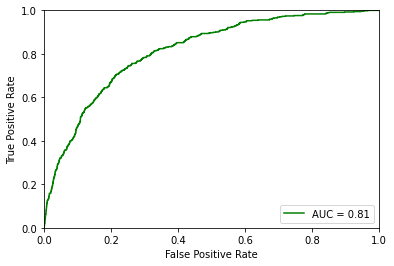

In [34]:
# plot ROC
pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('LG50_ROC.png')

In [ ]:
df_var = pd.DataFrame(zip(X_train.columns, logreg.coef_[0]))
df_var.sort_values(by = [1], inplace = True, ascending = False, key = abs)
df_var

,0,1
15,Race_Asian,-5.519197
17,Race_Hispanic,-4.587140
16,Race_Black,-4.304650
18,Race_Other,-4.172922
19,Race_White,-2.734431
2,AlcoholDrinking,-2.336427
22,Diabetic_Yes (during pregnancy),-2.303795
20,"Diabetic_No, borderline diabetes",-1.225688
11,Asthma,-0.869965
8,PhysicalActivity,-0.794103


Text(0, 0.5, 'FEATURE NAMES')

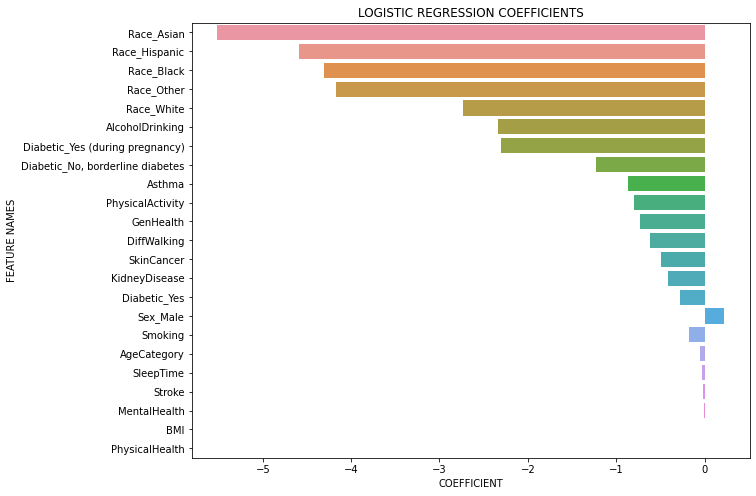

In [ ]:
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=df_var[1], y=df_var[0])
#Add chart labels
plt.title('LOGISTIC REGRESSION COEFFICIENTS')
plt.xlabel('COEFFICIENT')
plt.ylabel('FEATURE NAMES')
#plt.savefig('logreg_fi.png')
#plt.savefig('logreg_fi.pdf')

`scikit-learn` doesn't support statistical inferences, so we use `statsmodel` for this.

In [ ]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.555043
         Iterations 6
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.199     
Dependent Variable:       HeartDisease          AIC:                   50312.8819
Date:                     2022-04-20 07:19      BIC:                   50513.4572
No. Observations:         45282                 Log-Likelihood:        -25133.   
Df Model:                 22                    LL-Null:               -31363.   
Df Residuals:             45259                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           6.0000                                                 
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------